# Modeling

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-6413d9631603>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
df = pd.read_csv('../data/modeling_df.csv')

In [3]:
# Concatenate text columns to Countvectorize & Model
df['text'] = df['title'] + " " + df['body']

In [4]:
df.head(1)

,title,body,subreddit,body_word_count,body_character_length,title_character_length,title_upper_case_ratio,text
0,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them,mike bloomberg recently dropped out of the 2020 presidential race after spending over 500 million dollars of his own money on his campaign even with this loss he is still worth over 55 billion dollars\n believe that this effortless spending on bloombergs part showcases the reality that is wealth inequality between the ultra rich and working class while i do not believe the rich should give up their fortunes i do believe that any arguments against taxing them more is simply propaganda from those who hold the wealth and higher power at this point media outlets claim that taxing the super wealthy is unfair and would be detrimental to those below them due to trickle down effects there is also rhetoric that many self made billionaires worked hard for their fortunes and that if we as americans work hard we might be rich ourselves one day believe that moving forward we should push for much higher taxes on those earningworth more than 1 billion usd if the money bloomberg spent on his campaign went to actual communities that need funding actual change could have been possible social programs could benefit greatly from these funds and maybe we could afford to better fund national programs such as healthcare or family leave,1,211,1268,128,0.054688,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the 2020 presidential race after spending over 500 million dollars of his own money on his campaign even with this loss he is still worth over 55 billion dollars\n believe that this effortless spending on bloombergs part showcases the reality that is wealth inequality between the ultra rich and working class while i do not believe the rich should give up their fortunes i do believe that any arguments against taxing them more is simply propaganda from those who hold the wealth and higher power at this point media outlets claim that taxing the super wealthy is unfair and would be detrimental to those below them due to trickle down effects there is also rhetoric that many self made billionaires worked hard for their fortunes and that if we as americans work hard we might be rich ourselves one day believe that moving forward we should push for much higher taxes on those earningworth more than 1 billion usd if the money bloomberg spent on his campaign went to actual communities that need funding actual change could have been possible social programs could benefit greatly from these funds and maybe we could afford to better fund national programs such as healthcare or family leave


## Modeling with text only

In [5]:
df['text'] = df['text'].astype(str)

In [6]:
X = df['text']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 39, test_size = 0.3, stratify = y)

### Baseline Accuracy
It appears that my null model would accurately predict the subreddit from which a post originates ~ 50% of the time. 

In [7]:
y_test.value_counts(normalize = True)

0    0.504409
1    0.495591
Name: subreddit, dtype: float64

### CountVectorizer & Multinomial Naive Bayes

In [8]:
# Sklearn stopwords + 'cmv' & 'changemyview'
custom = ['cmv', 'changemyview', 'change', 'view', 'unpopular', 'opinion'] # my is in list of english stopwords
english_plus = text.ENGLISH_STOP_WORDS.union(custom) # English stopwords + my custom stopwords

In [9]:
# NLTK stopwords + 'cmv' + 'changemyview'
sw = stopwords.words('english')
sw.append('cmv')
sw.append('changemyview')

In [10]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [11]:
pipe_params = {
    'cvec__max_features': [4000, 5000, 6000, 7000, 8000],
    'cvec__max_df': [0.98],
    'cvec__min_df': [2],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [english_plus] 
}

* A note on stopwords: After trying all three (NLTK + cusom, Scikit-learn + custom, and just custom), I found that only using my list of custom stopwords gave me the highest accuracy score with minimum overfitting (training score: 0.835, test score 0.825). After some consideration, I have determined that this is likely because the greater number of stopwords in the CMV subreddit helps distinguish it from the UO subreddit. Since I will use the numerical features I developed during EDA to account for this in my final Random Forest model, I decided to stick with scikit-learn + custom stopwords for interpretability. 

In [12]:
gs = GridSearchCV( pipe ,
                  pipe_params, 
                  cv = 5) 

In [13]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.98],
                         'cvec__max_features': [4000, 5000, 6000, 7000, 8000],
                         'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', '

In [14]:
# Accuracy
gs.best_score_

0.8125300171526588

In [15]:
# Score model on testing set (Accuracy)
gs.score(X_test, y_test)

0.7865961199294532

In [16]:
gs.best_params_

{'cvec__max_df': 0.98,
 'cvec__max_features': 8000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
            'becoming',
    

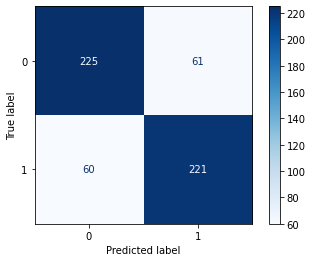

In [17]:
# Get predictions
preds = gs.predict(X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [18]:
# Calculate the specificity
tn / (tn + fp)

0.7867132867132867

### TfidfVectorizer & Multinomial Naive Bayes

In [19]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

In [20]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [21]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000, 6000],
    'tvec__max_df': [0.90, 0.95, 0.98],
    'tvec__min_df': [2, 10, 20],
    'tvec__stop_words': [english_plus],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [22]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(pipe_tvec, pipe_tvec_params, cv = 5, verbose = 1)

In [23]:
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:  9.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95, 0.98],
                         'tvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'tvec__min_df': [2, 10, 20],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                         

In [24]:
# Score model on training set (Accuracy)
gs_tvec.best_score_

0.8072412807318468

In [25]:
# Score model on testing set (Accuracy)
gs_tvec.score(X_test, y_test)

0.7848324514991182

In [26]:
gs_tvec.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 6000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
            'becoming',
     

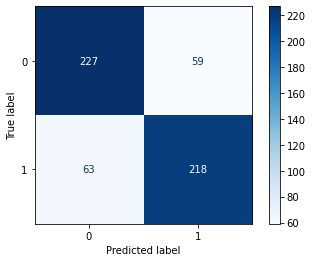

In [27]:
# Get predictions
preds = gs_tvec.predict(X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

In [28]:
# Calculate the specificity
tn / (tn + fp)

0.7937062937062938

### TfidfVectorizer + Logistic Regression

In [29]:
# Instantiate the transformer.
tvec = TfidfVectorizer()


In [30]:
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [31]:
pipe_tvec_lr_params = {
    'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'tvec__max_df': [0.90, 0.95, 0.98],
    'tvec__min_df': [2, 10, 20],
    'tvec__stop_words': [english_plus],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [32]:
# Instantiate GridSearchCV.
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, pipe_tvec_lr_params, cv = 5, verbose = 1)


In [33]:
gs_tvec_lr.fit(X_train, y_train)


Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed: 207.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tvec__max_df': [0.9, 0.95, 0.98],
                         'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 10, 20],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                    

In [34]:
gs_tvec_lr.best_score_


0.8238793596340767

In [35]:
gs_tvec_lr.score(X_test, y_test)


0.8077601410934744

In [36]:
gs_tvec_lr.best_params_


{'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
            'becoming',
    

## Modeling w/ Text and Numerical Features

In [37]:
# Dataframe with text and numerical data, all text data in 'text column'
df.drop(columns = {'title', 'body'},inplace = True)


In [38]:
df.head(1)


,subreddit,body_word_count,body_character_length,title_character_length,title_upper_case_ratio,text
0,1,211,1268,128,0.054688,cmv mike bloombergs campaign is proof that the ultra wealthy in the us can afford a higher tax rate with no ill effect on them mike bloomberg recently dropped out of the 2020 presidential race after spending over 500 million dollars of his own money on his campaign even with this loss he is still worth over 55 billion dollars\n believe that this effortless spending on bloombergs part showcases the reality that is wealth inequality between the ultra rich and working class while i do not believe the rich should give up their fortunes i do believe that any arguments against taxing them more is simply propaganda from those who hold the wealth and higher power at this point media outlets claim that taxing the super wealthy is unfair and would be detrimental to those below them due to trickle down effects there is also rhetoric that many self made billionaires worked hard for their fortunes and that if we as americans work hard we might be rich ourselves one day believe that moving forward we should push for much higher taxes on those earningworth more than 1 billion usd if the money bloomberg spent on his campaign went to actual communities that need funding actual change could have been possible social programs could benefit greatly from these funds and maybe we could afford to better fund national programs such as healthcare or family leave


In [39]:
#train/test/split
features = ['body_word_count', 'body_character_length', 'title_character_length', 'title_upper_case_ratio', 'text']
X = df[features]
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 39, stratify = y)


### Baseline Accuracy

In [40]:
# baseline accuracy for training & test sets
y_test.value_counts(normalize = True)


0    0.504409
1    0.495591
Name: subreddit, dtype: float64

### Applying TfidfVectorizer to Text Data

In [41]:
tvec = TfidfVectorizer(stop_words = english_plus,
                       max_df = 0.9,
                       min_df = 10,
                       ngram_range = (1,1)) 


In [42]:
# Tfidfvectorize just the text data

X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(), 
                          columns=tvec.get_feature_names())

X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(), 
                          columns=tvec.get_feature_names())

In [43]:
# Reset indices on all dataframes
X_train_tvec.reset_index(drop = True, inplace = True)

X_test_tvec.reset_index(drop = True, inplace = True)

X_train.reset_index(drop = True, inplace = True)

X_test.reset_index(drop = True, inplace = True)


In [44]:
# concatenate training and test datasets
combined_X_train = pd.concat([X_train_tvec, X_train], axis = 1)

combined_X_test = pd.concat([X_test_tvec, X_test], axis = 1)

In [45]:
# Drop text column
combined_X_train.drop(columns = 'text', inplace=True)
combined_X_test.drop(columns = 'text', inplace = True)

In [46]:
# Export as csv's
combined_X_train.to_csv('../data/X_train.csv', index = False )
combined_X_test.to_csv('../data/X_test.csv', index = False)
y_train.to_csv('../data/y_train.csv', index = False)
y_test.to_csv('../data/y_test.csv', index = False)

In [47]:
combined_X_test.shape, combined_X_train.shape

((567, 2261), (1323, 2261))

In [48]:
y_test.shape, y_train.shape

((567,), (1323,))

In [76]:
combined_X_train.sum().sort_values(ascending = False)

body_character_length     1.983553e+06
body_word_count           3.360660e+05
title_character_length    1.270920e+05
people                    6.848857e+01
title_upper_case_ratio    5.834421e+01
just                      4.924023e+01
like                      4.715028e+01
dont                      3.657586e+01
think                     3.411002e+01
im                        3.178346e+01
time                      2.797755e+01
want                      2.762841e+01
know                      2.613815e+01
make                      2.585584e+01
don                       2.567662e+01
feel                      2.456566e+01
way                       2.435598e+01
good                      2.355948e+01
really                    2.246428e+01
say                       2.244339e+01
women                     2.199432e+01
person                    2.137672e+01
things                    2.117628e+01
better                    2.008812e+01
need                      1.998148e+01
believe                  

In [77]:
combined_X_test.sum().sort_values(ascending = False)

body_character_length     905290.000000
body_word_count           153793.000000
title_character_length    55291.000000 
people                    29.687812    
title_upper_case_ratio    24.053026    
just                      22.728830    
like                      21.806857    
dont                      17.504742    
think                     15.447283    
im                        13.023228    
time                      12.366693    
way                       12.170287    
want                      12.025630    
know                      11.512986    
good                      10.324959    
really                    10.194001    
make                      10.014725    
things                    9.970568     
kids                      9.873217     
don                       9.844960     
women                     9.500743     
feel                      9.398504     
men                       9.191866     
say                       9.130940     
person                    8.894018     


### Logistic Regression w/ GridSearchCV

#### Pipe 1

In [49]:
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())    
])

In [50]:
pipe_lr_params = {'ss__with_mean': [True, False],
                  'ss__with_std' : [True, False],
                  'lr__penalty' : ['l2'],                       
                  'lr__C' :[1, 0.1, 0.001, 10],
                  'lr__solver': ['lbfgs', 'newton-cg'],
                  'lr__max_iter': [1000, 2000, 3000]
                 
                 }

In [51]:
# Instantiate our GridSearchCV object.
pipe_lr_gridsearch = GridSearchCV(pipe_lr, 
                                 pipe_lr_params, 
                                 cv = 5, 
                                 verbose=1)


In [52]:
pipe_lr_gridsearch.fit(combined_X_train, y_train)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 74.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1, 0.1, 0.001, 10],
                         'lr__max_iter': [1000, 2000, 3000],
                         'lr__penalty': ['l2'],
                         'lr__solver': ['lbfgs', 'newton-cg'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [53]:
pipe_lr_gridsearch.best_score_


0.8458147512864495

In [54]:
pipe_lr_gridsearch.best_params_


{'lr__C': 10,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'lr__solver': 'lbfgs',
 'ss__with_mean': True,
 'ss__with_std': False}

In [55]:
pipe_lr_gridsearch.score(combined_X_test, y_test)

0.8571428571428571

In [56]:
pipe_lr_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler(with_std=False)),
                ('lr', LogisticRegression(C=10, max_iter=1000))])

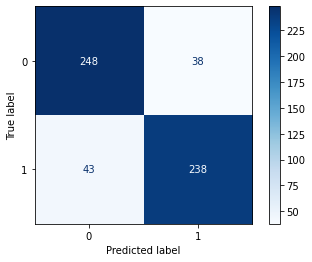

In [57]:
# Get predictions
preds = pipe_lr_gridsearch.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(pipe_lr_gridsearch, combined_X_test, y_test, cmap='Blues', values_format='d');


In [58]:
# Calculate the specificity
tn / (tn + fp)


0.8671328671328671

#### Pipe 2

In [59]:
pipe_lr2 = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())    
])

In [60]:
pipe_lr2_params = {'ss__with_mean': [True, False],
                  'ss__with_std' : [True, False],
                  'lr__penalty' : ['l1'],
                  'lr__C' :[1, 0.1, 0.001, 10],
                  'lr__solver': ['liblinear'],
                  'lr__max_iter': [1000, 2000, 3000]
                 
                 }

In [61]:
# Instantiate our GridSearchCV object.
pipe_lr2_gridsearch = GridSearchCV(pipe_lr2, 
                                 pipe_lr2_params, 
                                 cv=5, 
                                 verbose=1)

In [62]:
pipe_lr2_gridsearch.fit(combined_X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [1, 0.1, 0.001, 10],
                         'lr__max_iter': [1000, 2000, 3000],
                         'lr__penalty': ['l1'], 'lr__solver': ['liblinear'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [63]:
pipe_lr2_gridsearch.best_score_

0.835251572327044

In [64]:
pipe_lr2_gridsearch.best_params_

{'lr__C': 1,
 'lr__max_iter': 1000,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear',
 'ss__with_mean': False,
 'ss__with_std': False}

In [65]:
pipe_lr2_gridsearch.score(combined_X_test, y_test)

0.8818342151675485

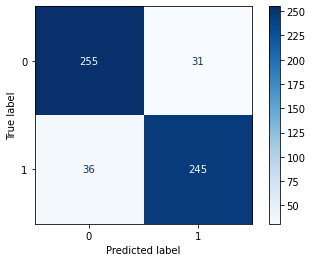

In [66]:
# Get predictions
preds = pipe_lr2_gridsearch.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(pipe_lr2_gridsearch, combined_X_test, y_test, cmap='Blues', values_format='d');

In [67]:
# Calculate the specificity
tn / (tn + fp)


0.8916083916083916

### RandomForest & ExtraTrees

In [68]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
cross_val_score(rf, combined_X_train, y_train).mean(), cross_val_score(et, combined_X_train, y_train).mean()

(0.8919268153230417, 0.8344825614636935)

In [69]:
#Will stick with RandomForest
params = {
    'n_estimators': [75, 100, 125],
    'max_depth' : [None, 3, 4],
    'max_features': ['auto', None]
}
gs = GridSearchCV(rf, param_grid = params)
gs.fit(combined_X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 4],
                         'max_features': ['auto', None],
                         'n_estimators': [75, 100, 125]})

In [70]:
gs.best_score_


0.9092853058890794

In [71]:
gs.best_params_


{'max_depth': None, 'max_features': None, 'n_estimators': 125}

In [72]:
gs.score(combined_X_test, y_test)


0.9118165784832452

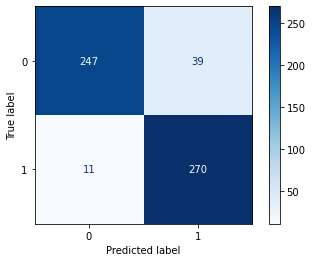

In [73]:
# Get predictions
preds = gs.predict(combined_X_test)

# View confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, combined_X_test, y_test, cmap='Blues', values_format='d');


In [74]:
# Calculate the specificity
tn / (tn + fp)


0.8636363636363636